In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data_energy =pd.read_csv('daily_total_energy.csv')
weather_data = pd.read_csv('data_weather.csv')

#### Data preparation

In [3]:


data_energy = data_energy.rename(columns={'Date': 'date'})
# Convert date string to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y%m%d')
data_energy['date'] = pd.to_datetime(data_energy['date'], format='%Y-%m-%d')

# Convert data in datetime format to string format
weather_data['date'] = weather_data['date'].dt.strftime('%Y-%m-%d')
data_energy['date'] = data_energy['date'].dt.strftime('%Y-%m-%d')

# Merge two datasets
merged_data = pd.merge(data_energy, weather_data, on='date')

merged_data=pd.DataFrame(merged_data)
merged_data = merged_data.dropna()
merged_data.to_csv('merged_data.csv')

In [4]:
data = merged_data

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year, month, and day from 'date'
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Drop the 'date' column
data = data.drop(columns=['date'])

# Show the first few rows of the modified data
data.head()

,KWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month,day
0,90.385,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0,2011,11,23
1,213.412,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0,2011,11,24
2,303.993,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0,2011,11,25
3,420.976,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0,2011,11,26
4,444.883,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0,2011,11,27


#### Data preparation

In [5]:
# Sorting the dataset by year, month, and day
data_sorted = data.sort_values(by=['year', 'month', 'day'])

# Extracting features and target from the sorted dataset
X_sorted = data_sorted.drop(columns=['KWH'])
y_sorted = data_sorted['KWH']

# Splitting the data into train and test sets using time series split
# Using 80% of the data for training and 20% for testing
train_size = int(len(data_sorted) * 0.8)
X_train_sorted, X_test_sorted = X_sorted.iloc[:train_size], X_sorted.iloc[train_size:]
y_train_sorted, y_test_sorted = y_sorted.iloc[:train_size], y_sorted.iloc[train_size:]

In [6]:
# Creating interaction terms for weather-related features
X_train_sorted['cloud_sunshine_interaction'] = X_train_sorted['cloud_cover'] * X_train_sorted['sunshine']
X_test_sorted['cloud_sunshine_interaction'] = X_test_sorted['cloud_cover'] * X_test_sorted['sunshine']

# Creating lag features for KWH
X_train_sorted['KWH_lag1'] = y_train_sorted.shift(1)
X_test_sorted['KWH_lag1'] = y_test_sorted.shift(1).reindex_like(y_test_sorted)

# Filling any created NaN values after lagging
X_train_sorted.fillna(method='bfill', inplace=True)
X_test_sorted.fillna(method='bfill', inplace=True)

C:\Users\95420\AppData\Local\Temp\ipykernel_25308\3432470952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sorted['cloud_sunshine_interaction'] = X_train_sorted['cloud_cover'] * X_train_sorted['sunshine']
C:\Users\95420\AppData\Local\Temp\ipykernel_25308\3432470952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sorted['cloud_sunshine_interaction'] = X_test_sorted['cloud_cover'] * X_test_sorted['sunshine']
C:\Users\95420\AppData\Local\Temp\ipykernel_25308\3432470952.py:6: SettingWit

#### 1.baseline model-----liner regaression

In [13]:
def time_series_cv_metrics(model, X, y, tscv):
    mse_scores, mae_scores, r2_scores = [], [], []
    
    for train_index, test_index in tscv.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model_clone = model
        model_clone.fit(X_train_fold, y_train_fold)
        y_pred_fold = model_clone.predict(X_test_fold)
        
        fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
        fold_mae = mean_absolute_error(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        
        mse_scores.append(fold_mse)
        mae_scores.append(fold_mae)
        r2_scores.append(fold_r2)
        
    return np.mean(mse_scores), np.mean(mae_scores), np.mean(r2_scores)

In [15]:
tscv = TimeSeriesSplit(n_splits=5)  
# Calculate the correlation of each feature with the target variable
correlations = X_train_sorted.corrwith(y_train_sorted)

# Select features with an absolute correlation value greater than 0.1
selected_features = correlations[correlations.abs() > 0.1].index

# Update training data with only the selected features
X_train_selected = X_train_sorted[selected_features]

# Re-train the linear regression model with the selected features
lr_model_selected = LinearRegression()
lr_model_selected.fit(X_train_selected, y_train_sorted)

# Evaluate the model using time series cross-validation and calculate metrics
avg_mse_selected, avg_mae_selected, avg_r2_selected = time_series_cv_metrics(
    lr_model_selected, X_train_selected, y_train_sorted, tscv
)

avg_mse_selected, avg_mae_selected, avg_r2_selected


(4898597.149866737, 1564.114320406229, 0.7938492726415738)

In [16]:
correlations

cloud_cover                   0.145616
sunshine                     -0.102319
global_radiation             -0.075437
max_temp                     -0.122199
mean_temp                    -0.109280
min_temp                     -0.074045
precipitation                 0.069297
pressure                     -0.272180
snow_depth                   -0.016280
year                          0.609256
month                         0.095830
day                          -0.009261
cloud_sunshine_interaction   -0.041540
KWH_lag1                      0.995499
dtype: float64

In [70]:
selected_features

Index(['cloud_cover', 'sunshine', 'max_temp', 'mean_temp', 'pressure', 'year',
       'KWH_lag1'],
      dtype='object')

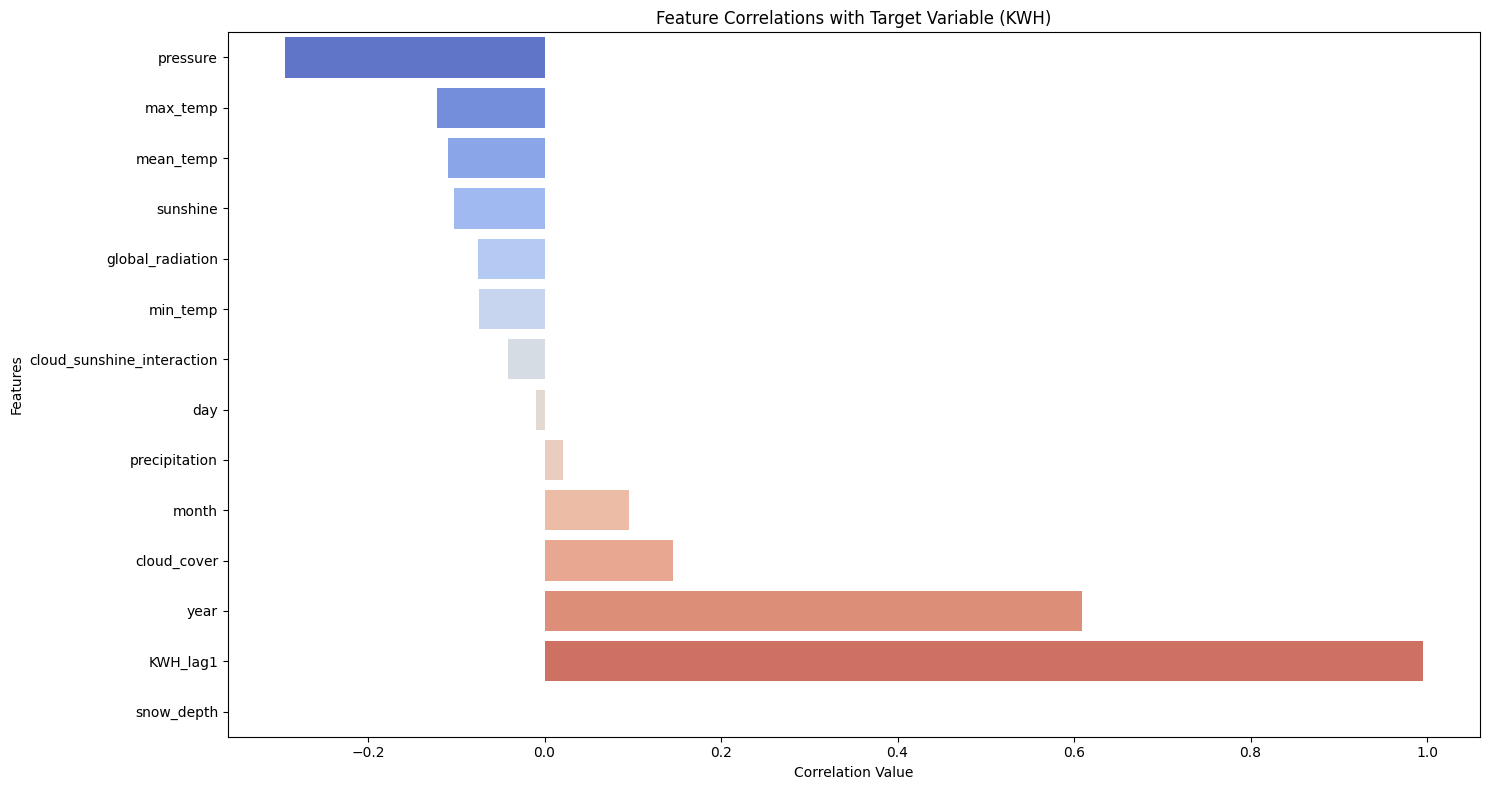

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the correlations of features with the target variable
plt.figure(figsize=(15, 8))
correlations_sorted = correlations.sort_values()
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")
plt.title("Feature Correlations with Target Variable (KWH)")
plt.xlabel("Correlation Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


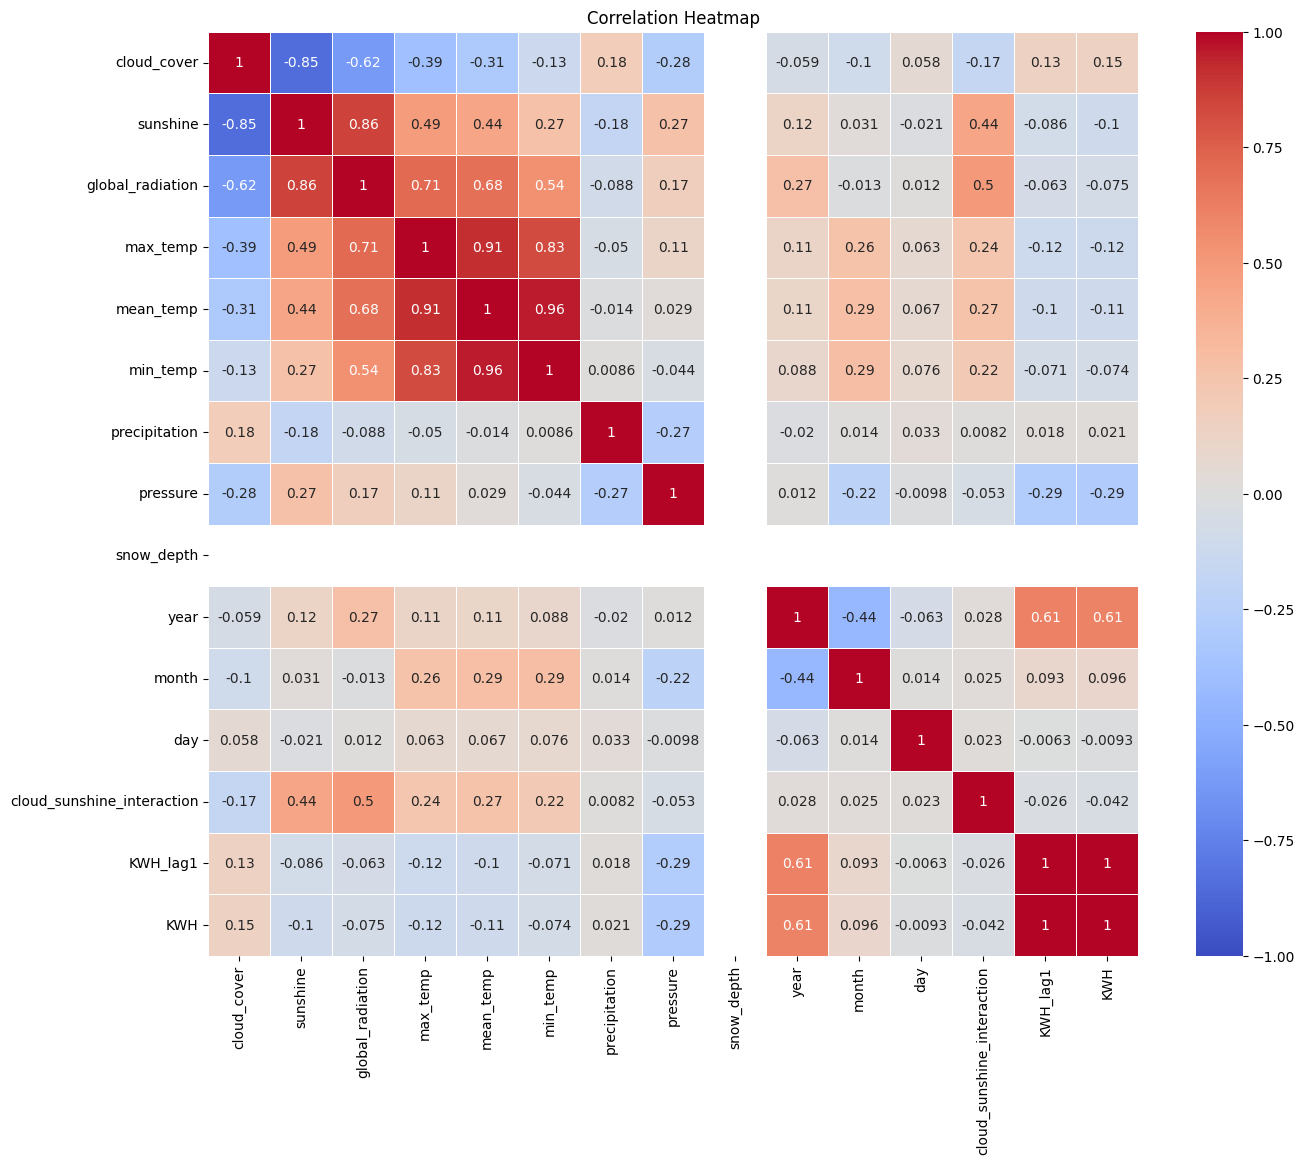

In [78]:
# Calculate the correlation matrix for the cleaned training data
corr_matrix = X_train_cleaned.join(y_train_sorted).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


In [18]:
# Predict using the linear regression model on the test set
X_test_selected = X_test_sorted[selected_features]
y_test_pred_lr = lr_model_selected.predict(X_test_selected)

# Calculate the metrics for the test set
test_mse_lr = mean_squared_error(y_test_sorted, y_test_pred_lr)
test_mae_lr = mean_absolute_error(y_test_sorted, y_test_pred_lr)
test_r2_lr = r2_score(y_test_sorted, y_test_pred_lr)

test_mse_lr, test_mae_lr, test_r2_lr


(6198582.192847583, 1882.4038126961161, 0.7665332265373096)

#### Random forecast

In [20]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Define the objective function
def objective(params):
    model = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
    
    # Use time series cross-validation instead of regular cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    score = cross_val_score(model, X_train_sorted, y_train_sorted, cv=tscv, scoring='r2').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Run the optimization
trials = Trials()
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=200, trials=trials, rstate=np.random.default_rng(42))

best_params


100%|██████████| 200/200 [05:41<00:00,  1.71s/trial, best loss: 2.0240237905782785]


{'max_depth': 44.0,
 'min_samples_leaf': 2.0,
 'min_samples_split': 5.0,
 'n_estimators': 17.0}

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Assume 'data' is your DataFrame and 'KWH' is your target variable.


# Define the random forest model parameters
params = {'max_depth': int(40),
          'min_samples_leaf': int(3),
          'min_samples_split': int(6),
          'n_estimators': int(11)}

# Initialize random forest model
rf_model = RandomForestRegressor(**params)

# Define the number of splits for cross-validation
# Define the number of splits for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store metrics for each fold
mse_values, mae_values, r2_values = [], [], []

# Perform time series cross-validation
for train_index, val_index in tscv.split(X_train_cleaned):
    # Create training and validation datasets for current fold
    X_train_fold, X_val_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[val_index]
    y_train_fold, y_val_fold = y_train_sorted.iloc[train_index], y_train_sorted.iloc[val_index]

    # Train model on current fold
    rf_model.fit(X_train_fold, y_train_fold)

    # Make predictions and evaluate model on validation set of current fold
    y_val_pred = rf_model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)

    # Append metrics for current fold to lists
    mse_values.append(mse)
    mae_values.append(mae)
    r2_values.append(r2)

# Calculate and print the mean metrics over all folds
mean_mse = np.mean(mse_values)
mean_mae = np.mean(mae_values)
mean_r2 = np.mean(r2_values)

print('Cross-Validation Metrics: ')
print(f'Mean MSE: {mean_mse}')
print(f'Mean MAE: {mean_mae}')
print(f'Mean R2 Score: {mean_r2}')

# Train a random forest model using all training data
rf_model.fit(X_train_cleaned, y_train_sorted)

# Evaluate the model
train_pred = rf_model.predict(X_train_cleaned)
test_pred = rf_model.predict(X_test_cleaned)

train_mse = mean_squared_error(y_train_sorted, train_pred)
test_mse = mean_squared_error(y_test_sorted, test_pred)

train_mae = mean_absolute_error(y_train_sorted, train_pred)
test_mae = mean_absolute_error(y_test_sorted, test_pred)

train_r2 = r2_score(y_train_sorted, train_pred)
test_r2 = r2_score(y_test_sorted, test_pred)

train_metrics = (train_mse, train_mae, train_r2)
test_metrics = (test_mse, test_mae, test_r2)

print('Train Metrics: ', train_metrics)
print('Test Metrics: ', test_metrics)


Cross-Validation Metrics: 
Mean MSE: 121401166.93505411
Mean MAE: 7865.791557475559
Mean R2 Score: -2.3944473802901354
Train Metrics:  (1090860.568624568, 670.649669611776, 0.9975786138202061)
Test Metrics:  (8757691.136765754, 2252.2474021143594, 0.670145554407142)
